# Digit Recognizer

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils import shuffle
sns.set()

from random import choices
from random import seed

## Importando Dataset

In [2]:
digits_PATH = '/kaggle/input/digit-recognizer/'

digits_train = pd.read_csv(digits_PATH+'train.csv')

In [3]:
X, y = digits_train.iloc[:,1:].values/255, digits_train.iloc[:,0].values

X = X.reshape(-1,28, 28, 1)

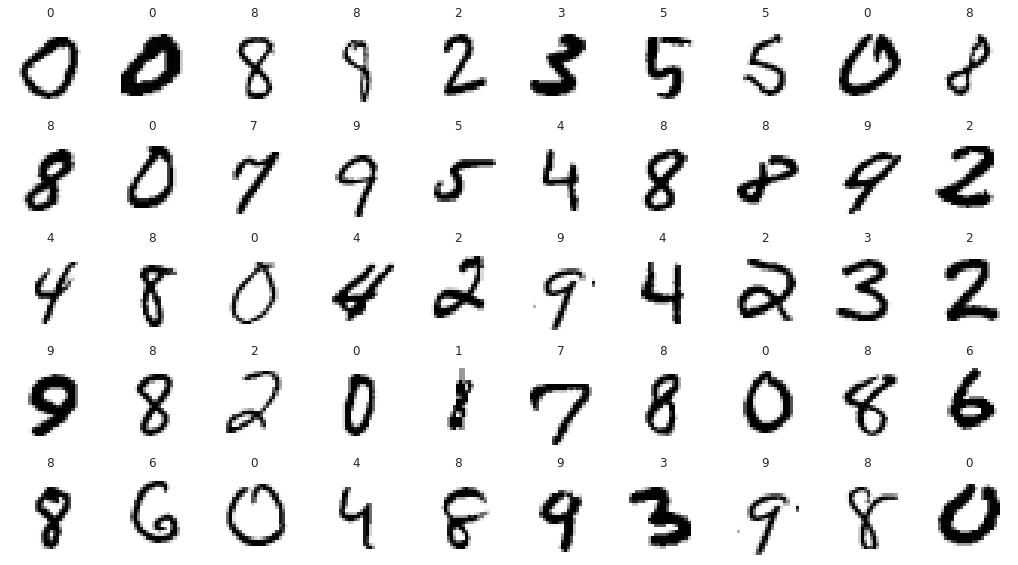

In [4]:
seed(1)

N_images = 50

# localização dos exemplos na matriz de dados 
rows = choices(range(0, 42000), k=N_images)

# selecionando os dígitos, já no formato de matriz
digitos = [X[i].reshape(28,28) for i in rows]
label_value = y[rows]

# criando figura do matplotlib
fig, ax = plt.subplots(5, int(len(rows)/5),figsize=(18,10))

# plotando!
for i in range(len(rows)):
    j = int(i/10)
    k = i - j*10
    ax[j, k].imshow(digitos[i], cmap = plt.cm.binary, interpolation="nearest")
    ax[j, k].set_title(label_value[i])
    ax[j, k].axis('off')

## Separando Treino, Validação e Teste

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=0)

[]

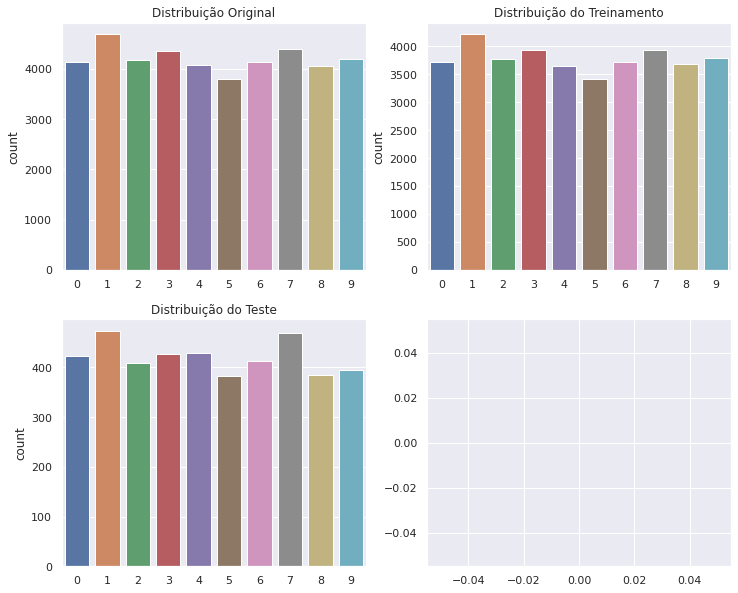

In [6]:
fig, ax = plt.subplots(2,2,figsize=(12,10))

sns.countplot(y, ax=ax[0,0])
ax[0,0].set_title('Distribuição Original')
sns.countplot(y_train, ax=ax[0,1])
ax[0,1].set_title('Distribuição do Treinamento')
sns.countplot(y_test, ax=ax[1,0])
ax[1,0].set_title('Distribuição do Teste')


plt.plot()

A distribuição dos números nos 3 no conjunto de teste e validação está próxima a ser homogênea.

## Funções Auxiliares

In [7]:
def plot_erros(model, X, target, cols=10, rows=5):

    y_pred = model.predict(X)
    y_pred = np.argmax(y_pred, axis=1)
    
    predicao = pd.DataFrame(data={'predicao':y_pred, 'target':target})
    predicao_erros = predicao[predicao.predicao != predicao.target]
    
    digitos = predicao_erros.index

    fig, ax = plt.subplots(rows, cols,figsize=(4*rows,1.2*cols))

    count = 0
    for row in range(0, rows):
        for col in range(0, cols):
            if count<len(digitos):
                ax[row, col].imshow(X[digitos[count],:,:,0], cmap = plt.cm.binary, interpolation="nearest")
                ax[row, col].set_title(f'{target[digitos[count]]} confused {y_pred[digitos[count]]}')
            ax[row, col].axis('off')
            count +=1
            

## Keras CNN

In [8]:
class MultiCNN():
    def __init__(self, model_generator, num_models=1):
        self.models = []
        self.create_models(model_generator, num_models)
        
    def create_models(self, model_generator, num_models=1):
        for i in range(0,num_models):
            m = keras.models.Sequential(model_generator())

            m.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

            self.models.append(m)
            
    def fit(self, train_inputs, train_targets, early_stop=True, verbose=2, batch_size=200, epochs=100):
        callback = []
        
        if early_stop:
            callback.append(keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=5))
        
        for m in self.models:
            X_train2, X_val2, y_train2, y_val2 = train_test_split(train_inputs, train_targets, test_size = 0.2)
            m.fit(X_train2, y_train2, 
                  batch_size= batch_size, 
                  epochs = epochs,
                  callbacks=callback,
                  validation_data = (X_val2, y_val2),
                  verbose=verbose
                 )
            
    def fit_generator(self, generator, train_inputs, train_targets, early_stop=True, verbose=2, batch_size=32, epochs=100):
        callback = []
        
        if early_stop:
            callback.append(keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=5))
        
        for m in self.models:
            X_train2, X_val2, y_train2, y_val2 = train_test_split(train_inputs, train_targets, test_size = 0.2)
            
            m.fit_generator(generator.flow(X_train2,y_train2, batch_size=batch_size),
                            epochs = epochs,
                            callbacks=callback,
                            validation_data = (X_val2, y_val2),
                            verbose=verbose
                            )
            
    def predict(self, test_inputs):
        prediction = [model.predict(test_inputs) for model in self.models]
        return sum(prediction)/len(prediction)
    
    def acuracia(self, test_input, test_target):
        prediction = self.predict(test_input)
        prediction = np.argmax(prediction, axis=1)
        return accuracy_score(prediction, test_target)
    
    def confusion_matrix(self, test_input, test_target):
        
        y_pred = self.predict(test_input)

        y_pred = np.argmax(y_pred, axis=1)

        confusao = confusion_matrix(y_pred, test_target)

        fig, ax = plt.subplots(1, figsize=(10,10))
        sns.heatmap(pd.DataFrame(confusao), ax=ax, cbar=False, annot=True)
        ax.set_title('Matriz de confusão', size=20)
        ax.set_yticklabels(ax.get_xticklabels(), rotation=0, size=15)
        ax.set_xticklabels(ax.get_yticklabels(), rotation=0, size=15)
        plt.show()
        
    def acuracia_individual(self, test_input, test_target):
        return [accuracy_score(np.argmax(m.predict(X_test), axis=1), y_test) for m in self.models]

In [9]:
def make_CNN():
    return  [

            keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(28, 28, 1)),
            keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),

            keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
            keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),

            keras.layers.Flatten(),
            keras.layers.Dense(units=64, activation="relu"),

            keras.layers.Dropout(0.2),

            keras.layers.Dense(units=10, activation="softmax")

            ]
    


multiCNN_default = MultiCNN(make_CNN, num_models=15)

multiCNN_default.fit(X_train, y_train, verbose = 0, early_stop=True)

multiCNN_default.acuracia(X_test, y_test)

0.99

## Adicionando uma camada ao final 

In [10]:
def make_CNN():
    return  [

                keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(28, 28, 1)),
                keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),

                keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
                keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),

                keras.layers.Flatten(),
                keras.layers.Dense(units=64, activation="relu"),
                keras.layers.Dense(units=64, activation="relu"),

                keras.layers.Dropout(0.2),

                keras.layers.Dense(units=10, activation="softmax")

            ]

multiCNN_plus_layer = MultiCNN(make_CNN, num_models=15)

multiCNN_plus_layer.fit(X_train, y_train, verbose = 0, early_stop=True)

multiCNN_plus_layer.acuracia(X_test, y_test)

0.9892857142857143

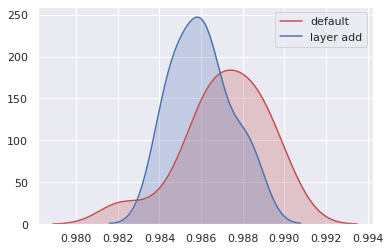

In [11]:
fig,axes = plt.subplots(1)
axes = sns.kdeplot(multiCNN_default.acuracia_individual(X_test, y_test), shade=True, color='r', label='default')
axes = sns.kdeplot(multiCNN_plus_layer.acuracia_individual(X_test, y_test), shade=True, color='b', label='layer add')

Não aumentou a qualidade do modelo

## Alteração da camada de Pooling para média

In [12]:
def make_CNN():
    return [

                keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(28, 28, 1)),
                keras.layers.AveragePooling2D(pool_size = (2,2), strides = 2),

                keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
                keras.layers.AveragePooling2D(pool_size = (2,2), strides = 2),

                keras.layers.Flatten(),
                keras.layers.Dense(units=64, activation="relu"),

                keras.layers.Dropout(0.2),

                keras.layers.Dense(units=10, activation="softmax")

                ]


multiCNN_pooling = MultiCNN(make_CNN, num_models=15)

multiCNN_pooling.fit(X_train, y_train, verbose = 0, early_stop=True)

multiCNN_pooling.acuracia(X_test, y_test)

0.9892857142857143

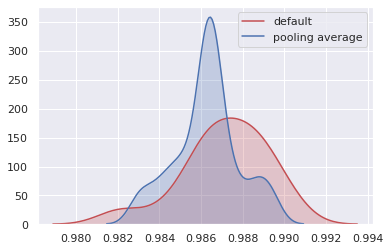

In [13]:
fig,axes = plt.subplots(1)
axes = sns.kdeplot(multiCNN_default.acuracia_individual(X_test, y_test), shade=True, color='r', label='default')
axes = sns.kdeplot(multiCNN_pooling.acuracia_individual(X_test, y_test), shade=True, color='b', label='pooling average')

Afetou negativamente o resultado

## Normalização por lote

In [14]:
def make_CNN():
    return [

                keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(28, 28, 1)),
                keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
                keras.layers.BatchNormalization(),

                keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
                keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
                keras.layers.BatchNormalization(),
    

                keras.layers.Flatten(),
                keras.layers.Dense(units=64, activation="relu"),

                keras.layers.Dropout(0.2),

                keras.layers.Dense(units=10, activation="softmax")

                ]

multiCNN_batch_normalization = MultiCNN(make_CNN, num_models=15)

multiCNN_batch_normalization.fit(X_train, y_train, verbose = 0, early_stop=True)

multiCNN_batch_normalization.acuracia(X_test, y_test)

0.9914285714285714

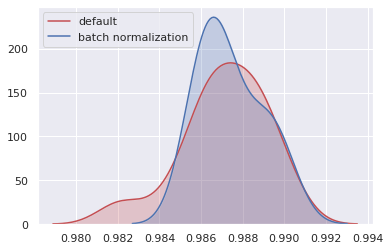

In [15]:
fig,axes = plt.subplots(1)
axes = sns.kdeplot(multiCNN_default.acuracia_individual(X_test, y_test), shade=True, color='r', label='default')
axes = sns.kdeplot(multiCNN_batch_normalization.acuracia_individual(X_test, y_test), shade=True, color='b', label='batch normalization')

Aumentou um pouco a qualidade do modelo.

## Adição de mais camadas de dropout

In [16]:
def make_CNN():
    return [

                keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(28, 28, 1)),
                keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
                keras.layers.BatchNormalization(),

                keras.layers.Dropout(0.2),
    
                keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
                keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
                keras.layers.BatchNormalization(),
    
                keras.layers.Dropout(0.2),

                keras.layers.Flatten(),
                keras.layers.Dense(units=64, activation="relu"),

                keras.layers.Dropout(0.2),

                keras.layers.Dense(units=10, activation="softmax")

                ]

multiCNN_dropout = MultiCNN(make_CNN, num_models=15)

multiCNN_dropout.fit(X_train, y_train, verbose = 0, early_stop=True)

multiCNN_dropout.acuracia(X_test, y_test)

0.9911904761904762

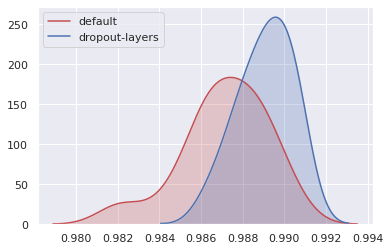

In [17]:
fig,axes = plt.subplots(1)
axes = sns.kdeplot(multiCNN_default.acuracia_individual(X_test, y_test), shade=True, color='r', label='default')
axes = sns.kdeplot(multiCNN_dropout.acuracia_individual(X_test, y_test), shade=True, color='b', label='dropout-layers')

Adição de dropouts após cada camada apresentou pequena melhora

## Aumento do número de neurônios na última camada

In [18]:
def make_CNN():
    return [

                keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(28, 28, 1)),
                keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
                keras.layers.BatchNormalization(),

                keras.layers.Dropout(0.2),
    
                keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
                keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
                keras.layers.BatchNormalization(),
    
                keras.layers.Dropout(0.2),

                keras.layers.Flatten(),
                keras.layers.Dense(units=200, activation="relu"),

                keras.layers.Dropout(0.2),

                keras.layers.Dense(units=10, activation="softmax")

                ]


multiCNN_200 = MultiCNN(make_CNN, num_models=15)

multiCNN_200.fit(X_train, y_train, verbose = 0, early_stop=True)

multiCNN_200.acuracia(X_test, y_test)

0.9916666666666667

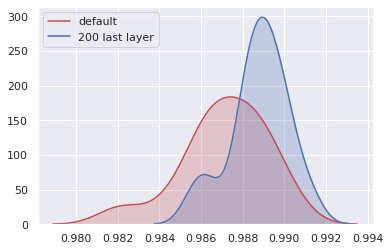

In [19]:
fig,axes = plt.subplots(1)
axes = sns.kdeplot(multiCNN_default.acuracia_individual(X_test, y_test), shade=True, color='r', label='default')
axes = sns.kdeplot(multiCNN_200.acuracia_individual(X_test, y_test), shade=True, color='b', label='200 last layer')

Houve melhora no modelo.

## Aumento do Tamanho do kernel

In [20]:
def make_CNN():
    return [

                keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu", input_shape=(28, 28, 1)),
                keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
                keras.layers.BatchNormalization(),

                keras.layers.Dropout(0.2),
    
                keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
                keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
                keras.layers.BatchNormalization(),
    
                keras.layers.Dropout(0.2),

                keras.layers.Flatten(),
                keras.layers.Dense(units=200, activation="relu"),

                keras.layers.Dropout(0.2),

                keras.layers.Dense(units=10, activation="softmax")

                ]

multiCNN_bigger_kernel = MultiCNN(make_CNN, num_models=15)

multiCNN_bigger_kernel.fit(X_train, y_train, verbose = 0, early_stop=True)

multiCNN_bigger_kernel.acuracia(X_test, y_test)

0.9921428571428571

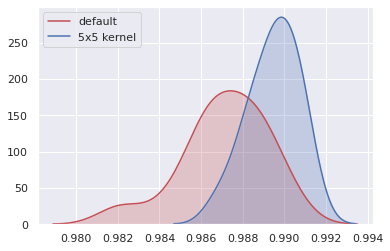

In [21]:
fig,axes = plt.subplots(1)
axes = sns.kdeplot(multiCNN_default.acuracia_individual(X_test, y_test), shade=True, color='r', label='default')
axes = sns.kdeplot(multiCNN_bigger_kernel.acuracia_individual(X_test, y_test), shade=True, color='b', label='5x5 kernel')

Não afetou a qualidade do modelo

## Diminuição número máximo de Epochs

In [22]:
def make_CNN():
    return [

                keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu", input_shape=(28, 28, 1)),
                keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
                keras.layers.BatchNormalization(),

                keras.layers.Dropout(0.2),
    
                keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
                keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
                keras.layers.BatchNormalization(),
    
                keras.layers.Dropout(0.2),

                keras.layers.Flatten(),
                keras.layers.Dense(units=200, activation="relu"),

                keras.layers.Dropout(0.2),

                keras.layers.Dense(units=10, activation="softmax")

                ]


multiCNN_min_epochs = MultiCNN(make_CNN, num_models=15)

multiCNN_min_epochs.fit(X_train, y_train, verbose = 0, early_stop=True, epochs=10)

multiCNN_min_epochs.acuracia(X_test, y_test)

0.9916666666666667

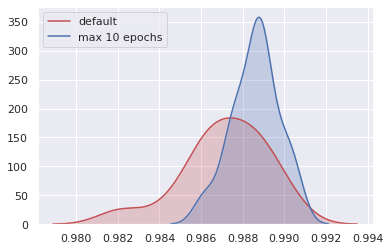

In [23]:
fig,axes = plt.subplots(1)
axes = sns.kdeplot(multiCNN_default.acuracia_individual(X_test, y_test), shade=True, color='r', label='default')
axes = sns.kdeplot(multiCNN_min_epochs.acuracia_individual(X_test, y_test), shade=True, color='b', label='max 10 epochs')

Aumentou a qualidade do modelo

## Adição de dados

In [24]:
datagen = keras.preprocessing.image.ImageDataGenerator(
                                                        featurewise_center=False,
                                                        samplewise_center=False,
                                                        featurewise_std_normalization=False,
                                                        samplewise_std_normalization=False,
                                                        zca_whitening=False,
                                                        zca_epsilon=1e-06,
                                                        rotation_range=10,
                                                        width_shift_range=0.1,
                                                        height_shift_range=0.1,
                                                        brightness_range=None,
                                                        zoom_range=0.1,
                                                        fill_mode="nearest",
                                                        cval=0.0,
                                                        horizontal_flip=False,
                                                        vertical_flip=False,
                                                        rescale=None,
                                                        preprocessing_function=None,
                                                        data_format=None,
                                                        validation_split=0.0,
                                                        dtype=None,
                                                    )

datagen.fit(X_train)

In [25]:
def make_CNN():
    return [

                keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu", input_shape=(28, 28, 1)),
                keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
                keras.layers.BatchNormalization(),

                keras.layers.Dropout(0.2),
    
                keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
                keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
                keras.layers.BatchNormalization(),
    
                keras.layers.Dropout(0.2),

                keras.layers.Flatten(),
                keras.layers.Dense(units=200, activation="relu"),

                keras.layers.Dropout(0.2),

                keras.layers.Dense(units=10, activation="softmax")

                ]


multiCNN_data_augmentation = MultiCNN(make_CNN, num_models=15)

multiCNN_data_augmentation.fit_generator(datagen, X_train, y_train, verbose = 0, early_stop=True)

multiCNN_data_augmentation.acuracia(X_test, y_test)

0.9959523809523809

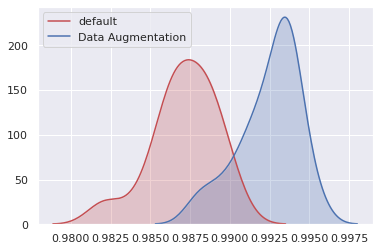

In [26]:
fig,axes = plt.subplots(1)
axes = sns.kdeplot(multiCNN_default.acuracia_individual(X_test, y_test), shade=True, color='r', label='default')
axes = sns.kdeplot(multiCNN_data_augmentation.acuracia_individual(X_test, y_test), shade=True, color='b', label='Data Augmentation')

Usar imagens geradas aumentaram a qualidade do modelo 

## Erros do Melhor modelo

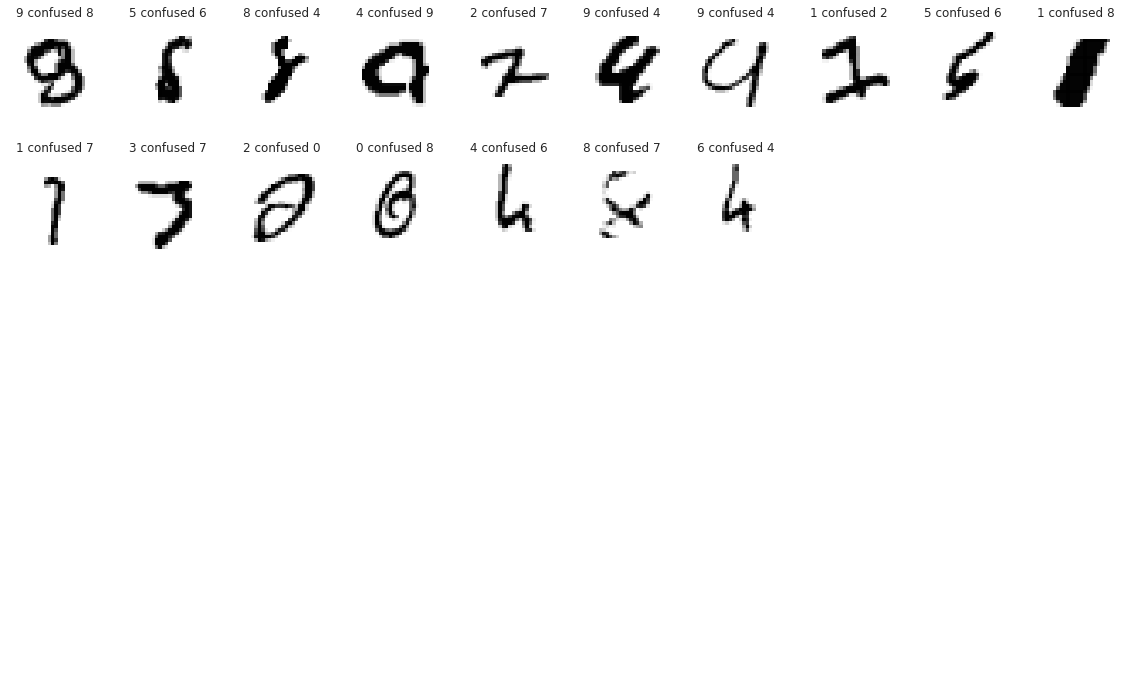

In [27]:
plot_erros(multiCNN_data_augmentation, X_test, y_test, cols=10, rows=5)

## Treinamento para submissão

In [28]:
def make_CNN():
    return [

                keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu", input_shape=(28, 28, 1)),
                keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
                keras.layers.BatchNormalization(),

                keras.layers.Dropout(0.2),
    
                keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
                keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
                keras.layers.BatchNormalization(),
    
                keras.layers.Dropout(0.2),

                keras.layers.Flatten(),
                keras.layers.Dense(units=200, activation="relu"),

                keras.layers.Dropout(0.2),

                keras.layers.Dense(units=10, activation="softmax")

                ]

multiCNN_final = MultiCNN(make_CNN, num_models=15)

multiCNN_final.fit_generator(datagen, X_train, y_train, verbose = 0, early_stop=True)

In [29]:
multiCNN_final.acuracia(X_test, y_test)

0.9954761904761905

In [30]:
submission = pd.read_csv(digits_PATH+'sample_submission.csv', index_col=0)
test = pd.read_csv(digits_PATH+'test.csv')/255
test = test.values.reshape(-1,28, 28, 1)

In [31]:
submission['Label'] = np.argmax(multiCNN_final.predict(test), axis=1)

In [32]:
submission.Label.value_counts()

1    3195
7    2902
3    2804
2    2803
0    2767
9    2762
4    2760
6    2748
8    2742
5    2517
Name: Label, dtype: int64

In [33]:
submission.to_csv('submission.csv')